# **"Foot-Wear Sorting Using MobileNet"**


### The purpose of this notebook is to sort Foot-Wear images in a folder based on their class/type

#### **Libraries Used:**

>tensorflow

>keras

>shutil

>random

>os

>numpy

>matplotlib

>PIL

>seaborn

#### **How to use?**

>1. Take a small chunk of data from each class e.g. 500 images per class and create a small sorted dataset

>2. Upload it on Drive

>3. Use this dataset to train a Transfer Learning model e.g. MobileNet, ResNet etc. to get high performance

>4. Save the model weights

>5. Load the saved weights locally and use it to sort footwear images from the dataset


# +_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+

## **Mount Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Importing Libraries**

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from sklearn.metrics import confusion_matrix
import os
import shutil
import random
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import numpy as np

## **Plotting Data**

In [4]:
def load_random_images(base_path, num_images=5):
    classes = ['boot', 'sandal', 'shoe']
    images = {}

    for fw in classes:
        fw_path = os.path.join(base_path, 'Train', fw)
        all_images = os.listdir(fw_path)
        selected_images = random.sample(all_images, num_images)
        images[fw] = [os.path.join(fw_path, img) for img in selected_images]

    return images

In [5]:
def plot_images(images):
    num_classes = len(images)
    num_images_per_class = len(images[next(iter(images))])

    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(15, 10))

    for i, (fw, img_paths) in enumerate(images.items()):
        for j, img_path in enumerate(img_paths):
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(fw.capitalize(), fontsize=10, pad=5)

    plt.tight_layout()
    plt.show()

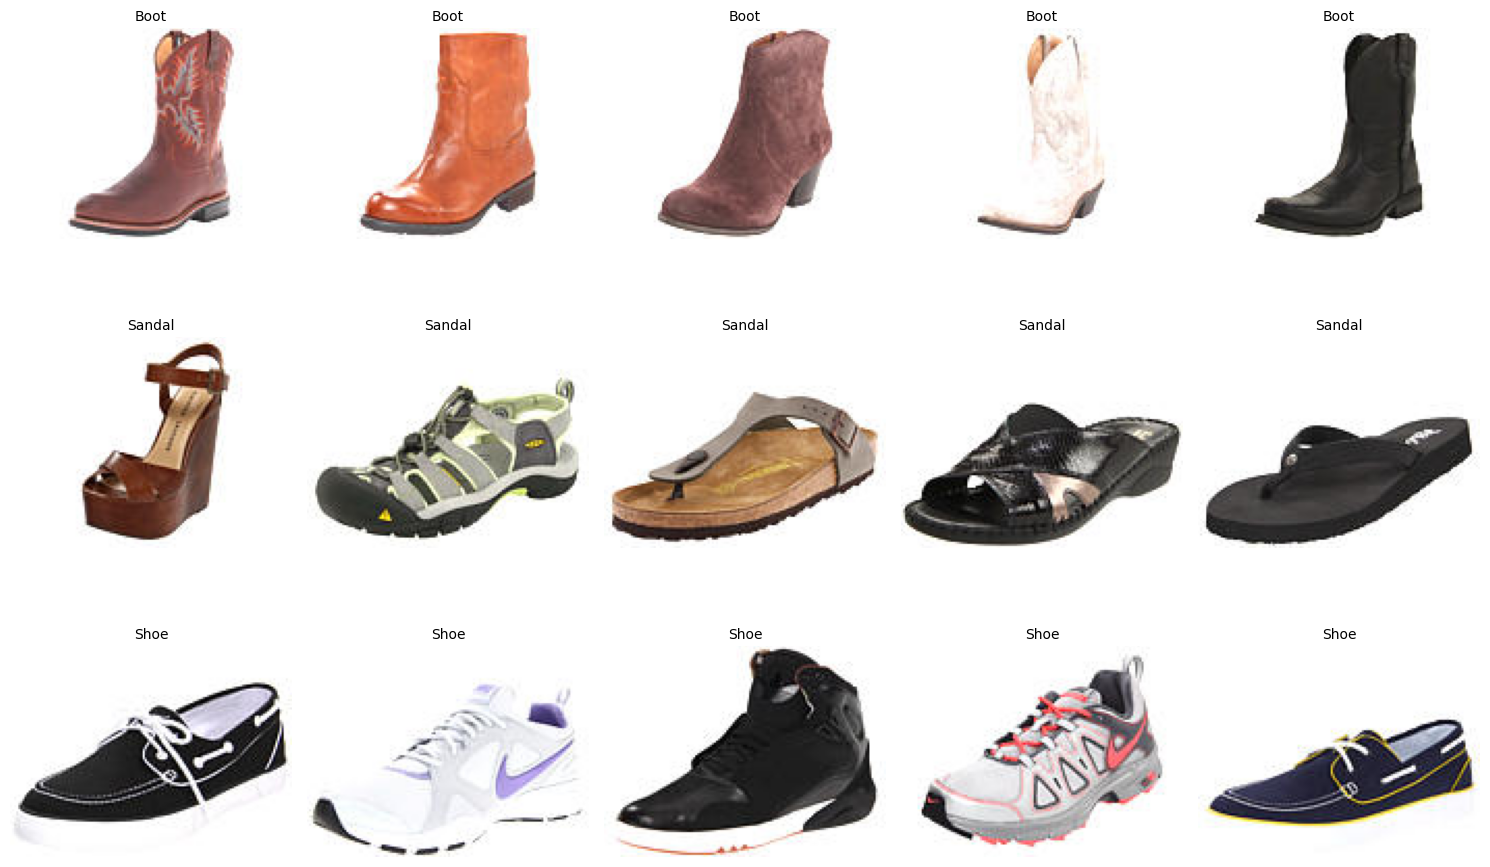

In [6]:
base_path = '/content/gdrive/MyDrive/FootWear_Sorting/dataset_F'
random_images = load_random_images(base_path)
plot_images(random_images)

## **Data Distribustion**

In [7]:
import os
import matplotlib.pyplot as plt

def count_images(base_path):
    classes = ['boot', 'sandal', 'shoe']
    distribution = {'Train': {}, 'Test': {}}

    for folder in ['Train', 'Test']:
        for fw in classes:
            fw_path = os.path.join(base_path, folder, fw)
            if os.path.exists(fw_path):
                count = len(os.listdir(fw_path))
                distribution[folder][fw] = count
            else:
                distribution[folder][fw] = 0  # In case the folder doesn't exist

    return distribution

In [8]:
def plot_distribution(distribution):
    classes = list(distribution['Train'].keys())
    train_counts = [distribution['Train'][fw] for fw in classes]
    test_counts = [distribution['Test'][fw] for fw in classes]

    x = range(len(classes))  # The x locations for the groups

    # Create bar plots
    plt.figure(figsize=(10, 6))
    bar_width = 0.35  # Width of the bars

    # Create bars for Train and Test
    plt.bar(x, train_counts, width=bar_width, label='Train', color='blue', alpha=0.7)
    plt.bar([p + bar_width for p in x], test_counts, width=bar_width, label='Test', color='red', alpha=0.7)

    # Adding labels and title
    plt.xlabel('Foot-Wear Class')
    plt.ylabel('Number of Images')
    plt.title('Data Distribution of Foot-Wear Images in Train and Test Folders')
    plt.xticks([p + bar_width / 2 for p in x], classes)  # Center the x-tick labels
    plt.legend()

    plt.tight_layout()
    plt.show()

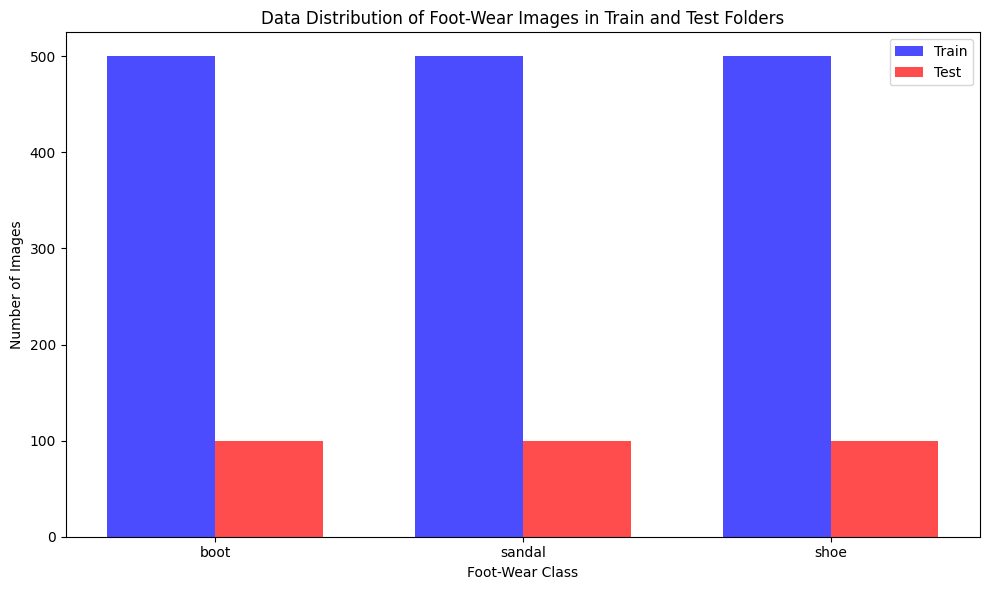

In [9]:
base_path = '/content/gdrive/MyDrive/FootWear_Sorting/dataset_F'
distribution = count_images(base_path)
plot_distribution(distribution)

## **Create Test and Val Generators**

In [10]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load the entire dataset
dataset = image_dataset_from_directory(
    directory='/content/gdrive/MyDrive/FootWear_Sorting/dataset_F/Train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

# Determine the number of validation samples
validation_split = 0.1
num_validation_samples = int(len(dataset) * validation_split)

# Split the dataset into training and validation sets
train_ds = dataset.skip(num_validation_samples)
validation_ds = dataset.take(num_validation_samples)

# Create a test dataset
test_ds = image_dataset_from_directory(
    directory='/content/gdrive/MyDrive/FootWear_Sorting/dataset_F/Test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224)
)

Found 1500 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


## **Normalize Images (make pixel Values b/w 0 and 1)**

In [12]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)
test_ds = test_ds.map(process)

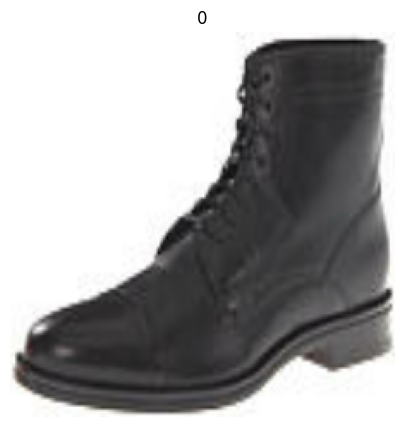

In [14]:
# Function to display an image after Normalization
def display_image_from_ds(dataset):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(5, 5))
        for i in range(1):
            ax = plt.subplot(1, 1, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(int(labels[i].numpy()))
            plt.axis("off")
        break

# Display one of the normalized images from train_ds
display_image_from_ds(train_ds)

## **Training Model**

In [22]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, Model

input_shape = (224, 224, 3)

base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

inputs = layers.Input(shape=input_shape)

x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(3, activation='softmax')(x)

model = Model(inputs, outputs)


In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 482ms/step - accuracy: 0.5546 - loss: 0.9789 - val_accuracy: 0.9219 - val_loss: 0.2541
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.8458 - loss: 0.3583 - val_accuracy: 0.9219 - val_loss: 0.2039
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9089 - loss: 0.2578 - val_accuracy: 0.9766 - val_loss: 0.1103
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9127 - loss: 0.2383 - val_accuracy: 0.9766 - val_loss: 0.1212
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9409 - loss: 0.1862 - val_accuracy: 0.9609 - val_loss: 0.1337
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9346 - loss: 0.1654 - val_accuracy: 0.9375 - val_loss: 0.1600
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9375 - loss: 0.1745 - val_accuracy: 0.9609 - val_loss: 0.1412
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.9457 - loss: 0.1532 - val_accuracy: 

Text(0.5, 1.0, 'Training and Validation Accuracy')

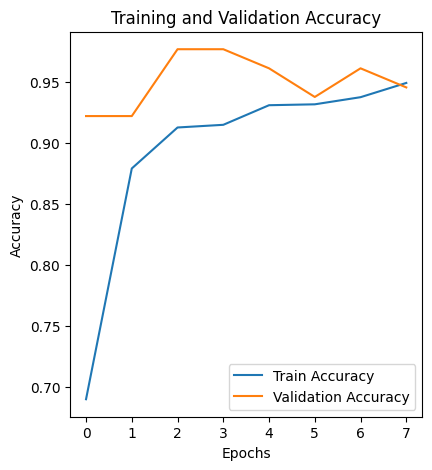

In [26]:
# Train and Val Accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

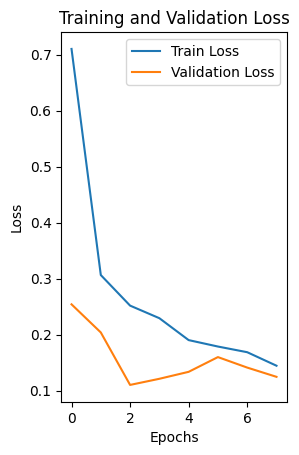

In [27]:
# Train and Val Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## **Save Model**

In [28]:
model.save('mobilenetv2_model.h5')

## **Load Model**

In [2]:
from tensorflow.keras.models import load_model

loaded_model = tf.keras.models.load_model('mobilenetv2_model.h5')

## **Model Testing and Confusion Matrix**

In [30]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = loaded_model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step - accuracy: 0.9393 - loss: 0.1886
Test accuracy: 94.67%
Test loss: 0.16610589623451233


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


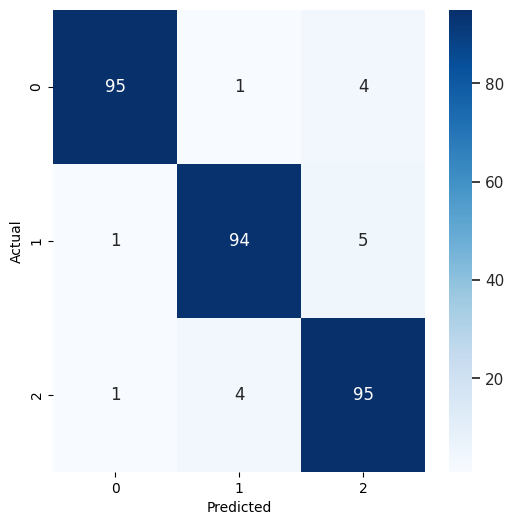

In [31]:
# Generate predictions and true labels for the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = loaded_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()


## **Predictions on Test data**

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


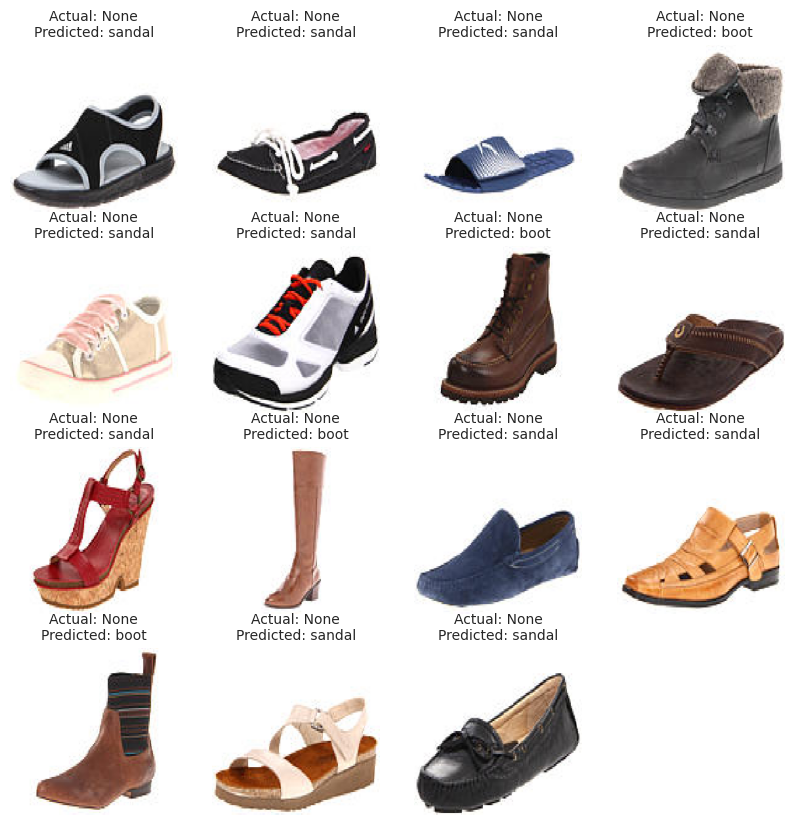

In [32]:
from tensorflow.keras.preprocessing import image

def predict_and_plot_images(model, image_folder, class_names):
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')]

    plt.figure(figsize=(10, 10))

    for i, img_file in enumerate(image_files):
        # Load and preprocess the image
        img_path = os.path.join(image_folder, img_file)
        img = image.load_img(img_path, target_size=(256, 256))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        # Make prediction
        predictions = model.predict(img_array)
        predicted_label = np.argmax(predictions)

        # Extract actual class from the filename
        actual_label = None
        for class_name in class_names:
            if class_name in img_file:
                actual_label = class_name
                break

        # Plotting
        plt.subplot(4, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Actual: {actual_label}\nPredicted: {class_names[predicted_label]}", fontsize = 10)
        plt.axis('off')

    plt.show()


image_folder = '/content'  # Folder containing your images
classes = ['boot', 'sandal', 'shoe']
predict_and_plot_images(loaded_model, image_folder, classes)

## **Sorting Based on Prediction**
#### Take images from "all" folder and move them to a new folder "all_new" based on their predictions

In [6]:
def classify_and_move_images(model, image_folder, output_folder, class_names):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Create subfolders for each class
    for class_name in class_names:
        class_folder = os.path.join(output_folder, class_name)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)

    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')]

    # Process each image
    for img_file in image_files:
        img_path = os.path.join(image_folder, img_file)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        # Predict the class
        predictions = model.predict(img_array)
        predicted_label = np.argmax(predictions)

        destination_folder = os.path.join(output_folder, class_names[predicted_label])
        shutil.move(img_path, os.path.join(destination_folder, img_file))

    print("Images have been sorted and moved to the respective folders.")

In [7]:
image_folder = 'all' 
output_folder = 'all_new' 
classes = ['boot', 'sandal', 'shoe']

classify_and_move_images(loaded_model, image_folder, output_folder, classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━

In [9]:
for folder_name in os.listdir(output_folder):
    folder_path = os.path.join(output_folder, folder_name)

    if os.path.isdir(folder_path):
        print(f"{folder_name}: {len(os.listdir(folder_path))}")

boot: 5844
sandal: 6408
shoe: 2748


## **Conclusion**
#### All files have been successfully moved from one single folder to thier respective class subfolders in new dataset "all_new" with a very less miss-classification error. We observed that the missclassifications are mostly in "shoe" folder because it has images that are similar to boots and sandals as well. This error can be reduced by taking a bigger chunk of data e.g. 1000+ imgs/class to get the full essence of data and then retrain the model.